In [26]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
from config import postgress_pass
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score

In [27]:
engine = create_engine("postgresql+psycopg2://postgres:" + postgress_pass + "@localhost:5432/hotel_bookings_db")

# Reflect the existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(autoload_with=engine)
session = Session(engine)

In [28]:
engine.execute('SELECT * FROM hotel_bookings LIMIT 5').fetchall()

[(1, 0, 342, 2015, 7, 27, 1, 0, 0, 2, 0, 0, 0, 136, 3, 1, 0, 0, 0, 2, 2, 0, 3, 0, None, 0, 2, 0.0, 0, 0, 1),
 (1, 0, 737, 2015, 7, 27, 1, 0, 0, 2, 0, 0, 0, 136, 3, 1, 0, 0, 0, 2, 2, 0, 4, 0, None, 0, 2, 0.0, 0, 0, 1),
 (1, 0, 7, 2015, 7, 27, 1, 0, 1, 1, 0, 0, 0, 59, 3, 1, 0, 0, 0, 0, 2, 1, 0, 0, None, 0, 2, 75.0, 0, 0, 0),
 (1, 0, 13, 2015, 7, 27, 1, 0, 1, 1, 0, 0, 0, 59, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 2, 75.0, 0, 0, 0),
 (1, 0, 14, 2015, 7, 27, 1, 0, 2, 2, 0, 0, 0, 59, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 240, 0, 2, 98.0, 0, 1, 0)]

In [29]:
# Replace 'table_name' with the actual table name containing the CSV data
bookings_query = 'SELECT * FROM hotel_bookings'
bookings_df = pd.read_sql_query(bookings_query, engine)


bookings_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,room_type_fulfilled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,international
0,1,0,342,2015,7,27,1,0,0,2,...,0,3,0,NaN,0,2,0.0,0,0,1
1,1,0,737,2015,7,27,1,0,0,2,...,0,4,0,NaN,0,2,0.0,0,0,1
2,1,0,7,2015,7,27,1,0,1,1,...,1,0,0,NaN,0,2,75.0,0,0,0
3,1,0,13,2015,7,27,1,0,1,1,...,0,0,0,304.0,0,2,75.0,0,0,0
4,1,0,14,2015,7,27,1,0,2,2,...,0,0,0,240.0,0,2,98.0,0,1,0


In [30]:
# Drop Nulls
bookings_df = bookings_df.dropna(how='any')

In [31]:
bookings_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'room_type_fulfilled', 'booking_changes',
       'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'international'],
      dtype='object')

In [32]:
bookings_df.describe()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,room_type_fulfilled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,international
count,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,...,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000
mean,0.309083,0.390044,111.672256,2016.156487,6.594304,27.339427,15.784066,0.977875,2.589355,1.899466,...,0.109413,0.201698,0.122581,86.693382,2.615614,2.116652,104.618808,0.053217,0.605376,0.364803
std,0.462118,0.487762,107.671497,0.706228,3.020402,13.285191,8.793996,1.003935,1.905760,0.491053,...,0.312158,0.624792,0.329375,110.774548,18.783482,0.590669,50.034464,0.225717,0.799216,0.481377
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,26.000000,2016.000000,4.000000,17.000000,8.000000,0.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,9.000000,0.000000,2.000000,72.800000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,79.000000,2016.000000,7.000000,28.000000,16.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,14.000000,0.000000,2.000000,96.300000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,169.000000,2017.000000,9.000000,38.000000,24.000000,2.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,229.000000,0.000000,2.000000,127.800000,0.000000,1.000000,1.000000
max,1.000000,1.000000,629.000000,2017.000000,12.000000,53.000000,31.000000,16.000000,41.000000,26.000000,...,1.000000,18.000000,2.000000,535.000000,391.000000,3.000000,5400.000000,3.000000,5.000000,1.000000


## Are there more cancellations during specific months?

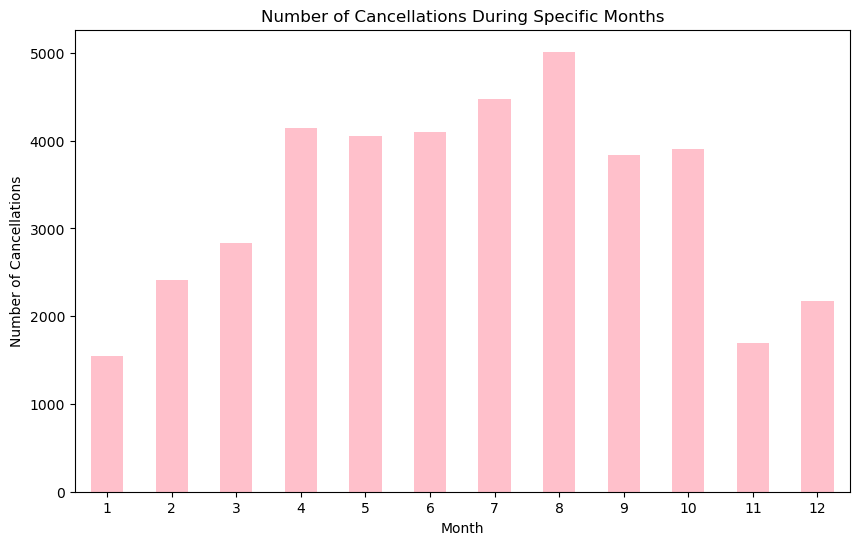

In [33]:
# Group the data by 'arrival_date_month' and count the number of cancellations in each month.
cancellations_by_month = bookings_df[bookings_df['is_canceled'] == 1].groupby('arrival_date_month').size()

# Create a bar plot to visualize the number of cancellations for each month.
plt.figure(figsize=(10, 6))
cancellations_by_month.plot(kind='bar', color='#FFC0CB')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.title('Number of Cancellations During Specific Months')
plt.xticks(rotation=0)
plt.show()

## Does customer type contribute to cancellations? 

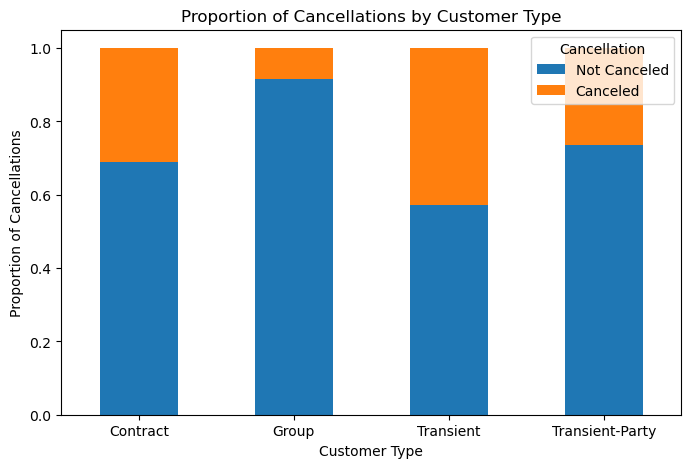

In [34]:
# Create a cross-tabulation between 'customer_type' and 'is_canceled' to get the count of cancellations for each customer type.
customer_type_cancellations = pd.crosstab(bookings_df['customer_type'], bookings_df['is_canceled'])

# Calculate the proportion of cancellations
customer_type_proportions = customer_type_cancellations.div(customer_type_cancellations.sum(axis=1), axis=0)

# Stacked bar plot
customer_type_proportions.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.xlabel('Customer Type')
plt.ylabel('Proportion of Cancellations')
plt.title('Proportion of Cancellations by Customer Type')
plt.legend(title='Cancellation', loc='upper right', labels=['Not Canceled', 'Canceled'])
plt.xticks([0, 1, 2, 3], ['Contract', 'Group', 'Transient', 'Transient-Party'], rotation=0)
plt.show()

## Does a specific country contribute to more or less cancellations?

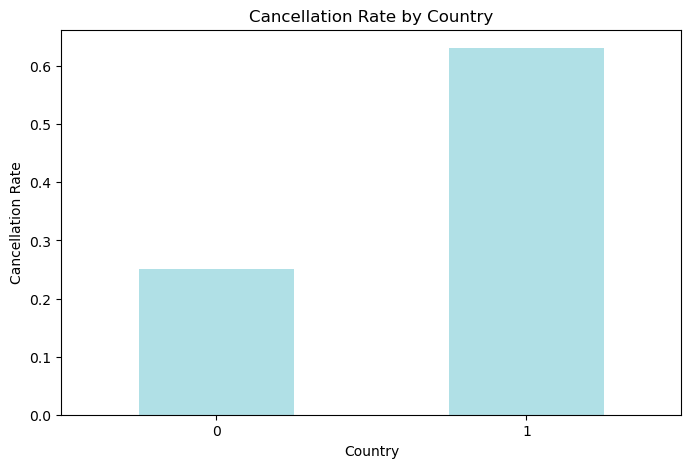

In [35]:
# 0- International, 1- Not international  How to put them in legend or xticks?????

# Group the data by 'international' and calculate the total number of bookings and cancellations.
country_counts = bookings_df.groupby('international')['is_canceled'].agg(['count', 'sum'])

# Calculate the cancellation rate.
country_counts['cancellation_rate'] = country_counts['sum'] / country_counts['count']

# Bar plot for cancellation rate by country
plt.figure(figsize=(8, 5))
country_counts['cancellation_rate'].plot(kind='bar', color='powderblue')
plt.xlabel('Country')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate by Country')
plt.xticks(rotation=0)
plt.show()

## Do different deposit types affect cancellations?

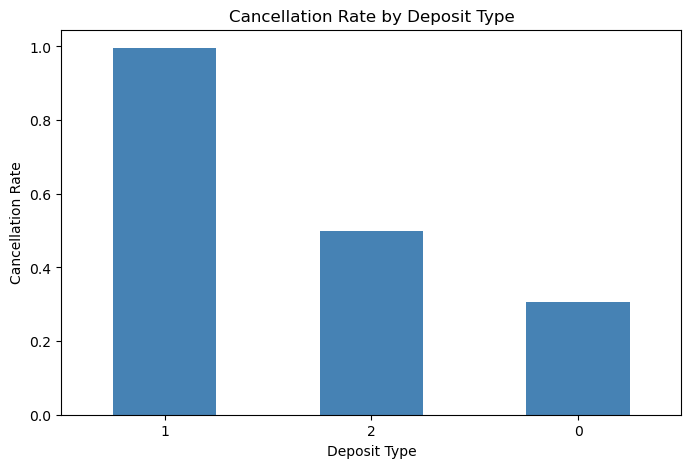

In [36]:
# 0- No Deposit, 1-Non-Refundable, 2-Refundable How to put these in a legend???

# Group the data by 'deposit_type' and calculate the total number of bookings and cancellations for each deposit plan.
deposit_counts = bookings_df.groupby('deposit_type')['is_canceled'].agg(['count', 'sum'])

# Calculate the cancellation rate.
deposit_counts['cancellation_rate'] = deposit_counts['sum'] / deposit_counts['count']

# Sort the data by cancellation rate in descending order to highlight the meal plans with higher cancellation rates.
deposit_counts = deposit_counts.sort_values(by='cancellation_rate', ascending=False)

# Grouped bar plot for cancellation rate by meal plan
plt.figure(figsize=(8, 5))
deposit_counts['cancellation_rate'].plot(kind='bar', color='steelblue')
plt.xlabel('Deposit Type')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate by Deposit Type')
plt.xticks( rotation=0)
plt.show()

## Does lead time affect cancellations?

<Figure size 800x500 with 0 Axes>

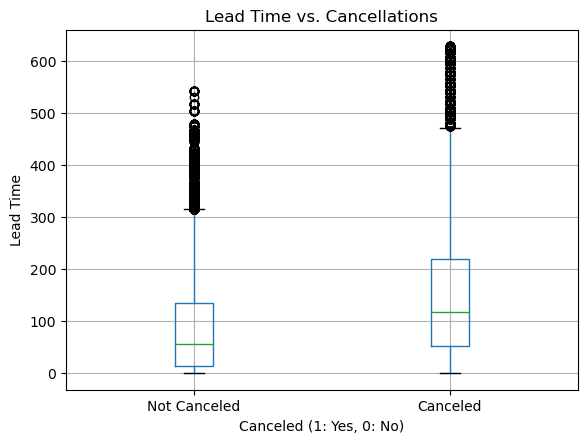

In [37]:
# Box plot
plt.figure(figsize=(8, 5))
box_plot = bookings_df.boxplot(column='lead_time', by='is_canceled', grid=True)
plt.xlabel('Canceled (1: Yes, 0: No)')
plt.ylabel('Lead Time')
plt.title('Lead Time vs. Cancellations')
plt.suptitle('')
plt.xticks([1, 2], ['Not Canceled', 'Canceled'])
plt.show()

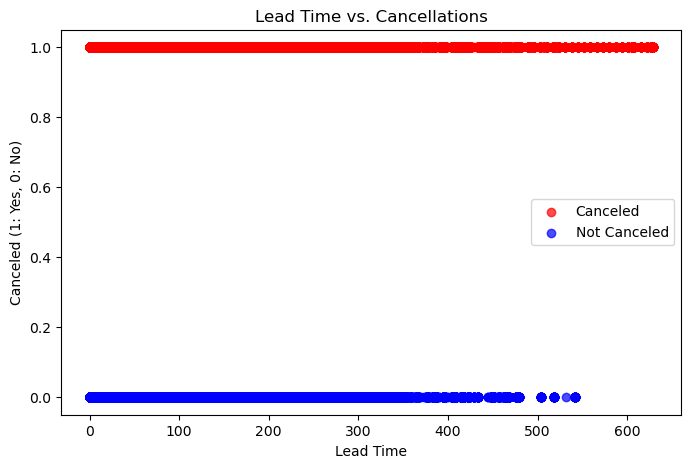

In [38]:
# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(bookings_df[bookings_df['is_canceled'] == 1]['lead_time'], bookings_df[bookings_df['is_canceled'] == 1]['is_canceled'], label='Canceled', color='red', alpha=0.7)
plt.scatter(bookings_df[bookings_df['is_canceled'] == 0]['lead_time'], bookings_df[bookings_df['is_canceled'] == 0]['is_canceled'], label='Not Canceled', color='blue', alpha=0.7)
plt.xlabel('Lead Time')
plt.ylabel('Canceled (1: Yes, 0: No)')
plt.title('Lead Time vs. Cancellations')
plt.legend()
plt.show()

## If a reserved room does not match the assigned room, does that lead to cancellations? 

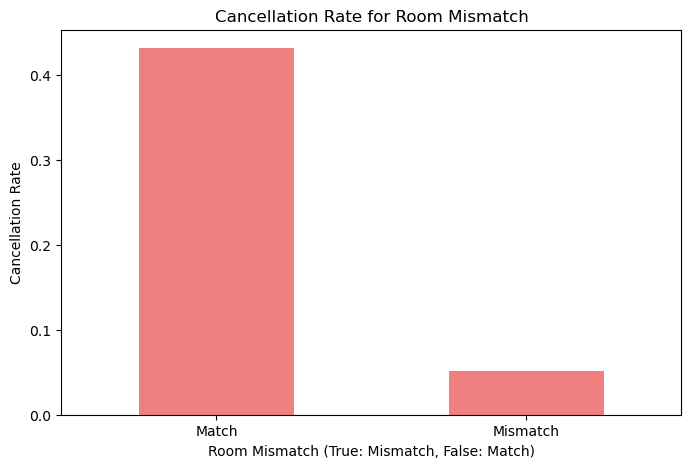

In [39]:
# Create a booleanfor bookings where reserved room type is not the same as assigned room type.
room_mismatch = bookings_df['reserved_room_type'] != bookings_df['assigned_room_type']

# Group the data by 'room_mismatch' and calculate the total number of bookings and cancellations for each case.
room_mismatch_counts = bookings_df.groupby(room_mismatch)['is_canceled'].agg(['count', 'sum'])

# Calculate the cancellation rate
room_mismatch_counts['cancellation_rate'] = room_mismatch_counts['sum'] / room_mismatch_counts['count']

# Bar plot
plt.figure(figsize=(8, 5))
room_mismatch_counts['cancellation_rate'].plot(kind='bar', color='lightcoral')
plt.xlabel('Room Mismatch (True: Mismatch, False: Match)')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate for Room Mismatch')
plt.xticks([0, 1], ['Match', 'Mismatch'], rotation=0)
plt.show()

In [40]:
# Get value counts of is_canceled column
bookings_df['is_canceled'].value_counts()

0    62856
1    40194
Name: is_canceled, dtype: int64

In [41]:
# Get ratio instead of raw numbers using normalize=True
expected_ratio = bookings_df['is_canceled'].value_counts(normalize=True)

# Round and then convert to percentage
expected_ratio = expected_ratio.round(4)*100

# convert to a DataFrame and store in variable 'is_canceled_ratios'
is_canceled_ratios = pd.DataFrame({'Expected':expected_ratio})
is_canceled_ratios

,Expected
0,61.0
1,39.0


In [42]:
stratified_sample = bookings_df.groupby('is_canceled').apply(
    lambda x: x.sample(frac=1)
)

stratified_sample = stratified_sample.droplevel(0)

stratified_sample.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,room_type_fulfilled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,international
22422,1,0,17,2016,3,12,19,2,4,2,...,0,0,0,241.0,0,2,55.41,1,2,0
86655,0,0,55,2016,4,15,6,0,1,2,...,1,0,0,56.0,0,3,104.00,0,0,1
46146,0,0,6,2015,12,51,17,0,2,1,...,0,0,0,7.0,0,2,74.69,0,0,0
107625,0,0,28,2017,3,11,14,0,2,1,...,0,0,0,1.0,0,3,65.00,0,0,0
49898,0,0,270,2016,4,17,20,0,4,2,...,0,0,0,21.0,187,3,80.00,0,0,0


In [43]:
stratified_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103050 entries, 22422 to 50259
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           103050 non-null  int64  
 1   is_canceled                     103050 non-null  int64  
 2   lead_time                       103050 non-null  int64  
 3   arrival_date_year               103050 non-null  int64  
 4   arrival_date_month              103050 non-null  int64  
 5   arrival_date_week_number        103050 non-null  int64  
 6   arrival_date_day_of_month       103050 non-null  int64  
 7   stays_in_weekend_nights         103050 non-null  int64  
 8   stays_in_week_nights            103050 non-null  int64  
 9   adults                          103050 non-null  int64  
 10  children                        103050 non-null  int64  
 11  babies                          103050 non-null  int64  
 12  meal         

In [44]:
# Ratio of selected items by is_canceled
stratified_ratio = stratified_sample['is_canceled'].value_counts(normalize=True)

# Convert to percentage
stratified_ratio = stratified_ratio.round(4)*100

# We did stratified sampling. So give it proper name
stratified_ratio.name = 'Stratified'

# Proving the stratified ratio matches the whole dataset ratio (is_canceled_ratios)
stratified_ratio.head()

0    61.0
1    39.0
Name: Stratified, dtype: float64

In [45]:
# Separate the features from the target "is_canceled"
y = stratified_sample["is_canceled"]
X = stratified_sample.drop(columns="is_canceled")

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

# Logistic Regression

In [47]:
# Creating logistic regression model called "model_lr"
model_lr = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000,)
model_lr

LogisticRegression(max_iter=10000, random_state=1)

In [48]:
# Train the data
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=1)

In [49]:
predictions_lr = model_lr.predict(X_test)
pd.DataFrame({"Prediction": predictions_lr, "Actual": y_test})

,Prediction,Actual
32048,0,0
7346,0,1
4428,0,1
40178,0,0
115344,0,0
...,...,...
20840,0,0
20872,0,0
18887,0,0
88874,0,0


In [50]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions_lr)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_lr)

In [51]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_lr))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,14091,1623
Actual 1,3805,6244


Accuracy Score : 0.7893102511353491
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     15714
           1       0.79      0.62      0.70     10049

    accuracy                           0.79     25763
   macro avg       0.79      0.76      0.77     25763
weighted avg       0.79      0.79      0.78     25763



In [52]:
# Displaying results
lr_acc = accuracy_score(y_test,predictions_lr)
lr_f1 = f1_score(y_test,predictions_lr)
lr_precision = precision_score(y_test,predictions_lr)
lr_recall = recall_score(y_test,predictions_lr)
lr_results = pd.DataFrame([['Logistic regression', lr_acc, lr_f1, lr_precision, lr_recall]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
lr_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Logistic regression,0.78931,0.697031,0.793695,0.621355


# Random Forest

In [53]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [54]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [55]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [56]:
# Create a random forest classifier
model_rf = RandomForestClassifier(n_estimators=500, random_state=78)

In [57]:
# Fitting the model
model_rf = model_rf.fit(X_train_scaled, y_train)

In [58]:
# Making predictions using the testing data
predictions_rf = model_rf.predict(X_test_scaled)

In [59]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions_rf)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_rf)

In [60]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_rf))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,14546,1168
Actual 1,1648,8401


Accuracy Score : 0.8906959593215076
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     15714
           1       0.88      0.84      0.86     10049

    accuracy                           0.89     25763
   macro avg       0.89      0.88      0.88     25763
weighted avg       0.89      0.89      0.89     25763



In [61]:
# Displaying results
rf_acc = accuracy_score(y_test,predictions_rf)
rf_f1 = f1_score(y_test,predictions_rf)
rf_precision = precision_score(y_test,predictions_rf)
rf_recall = recall_score(y_test,predictions_rf)
rf_results = pd.DataFrame([['Random Forest', rf_acc, rf_f1, rf_precision, rf_recall]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
rf_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Random Forest,0.890696,0.856458,0.877939,0.836004


In [62]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model_rf.feature_importances_
# We can sort the features by their importance
sorted(zip(model_rf.feature_importances_, X.columns), reverse=True)

[(0.11775304945764463, 'lead_time'),
 (0.0962921449058274, 'deposit_type'),
 (0.08144952303519361, 'country'),
 (0.07156674725657466, 'adr'),
 (0.06328625722231439, 'agent'),
 (0.06280267719665829, 'total_of_special_requests'),
 (0.05456361884939204, 'international'),
 (0.05181664297977392, 'arrival_date_day_of_month'),
 (0.04847170342761211, 'arrival_date_week_number'),
 (0.0404465698395408, 'market_segment'),
 (0.03433260562694057, 'stays_in_week_nights'),
 (0.031437223845542095, 'previous_cancellations'),
 (0.03023238042319954, 'room_type_fulfilled'),
 (0.028411034920214497, 'arrival_date_month'),
 (0.02559509782642754, 'arrival_date_year'),
 (0.023497405937713572, 'customer_type'),
 (0.02259554057439839, 'required_car_parking_spaces'),
 (0.022120388416587363, 'stays_in_weekend_nights'),
 (0.018143718437862572, 'booking_changes'),
 (0.017522734699450995, 'assigned_room_type'),
 (0.011646595477139695, 'meal'),
 (0.011606833034855036, 'adults'),
 (0.01113934328737377, 'reserved_room_t

<Axes: title={'center': 'Random Forest Features Importances'}, ylabel='1'>

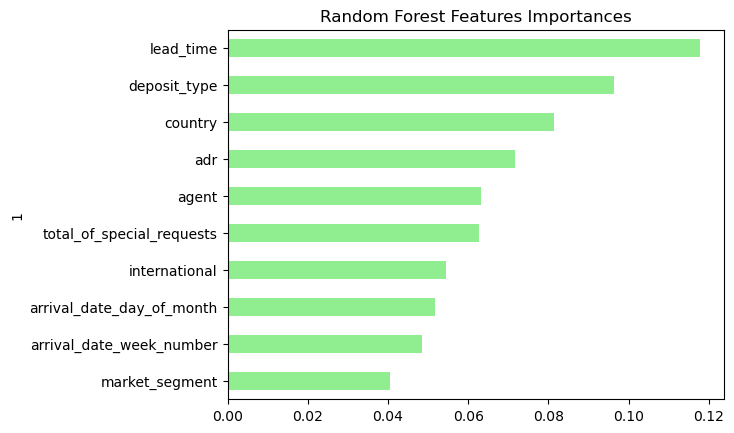

In [63]:
# Visualize the features by importance
rf_importances_df = pd.DataFrame(sorted(zip(model_rf.feature_importances_, X.columns), reverse=True))
rf_importances_df.set_index(rf_importances_df[1], inplace=True)
rf_importances_df.drop(columns=1, inplace=True)
rf_importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
rf_importances_sorted = rf_importances_df[:10].sort_values(by='Feature Importances')
rf_importances_sorted.plot(kind='barh', color='lightgreen', title= 'Random Forest Features Importances', legend=False)

# Decision Tree

In [64]:
# Creating the decision tree classifier instance
model_dt = tree.DecisionTreeClassifier()

In [65]:
# Fitting the model
model_dt = model_dt.fit(X_train_scaled, y_train)

In [66]:
# Making predictions using the testing data
predictions_dt = model_dt.predict(X_test_scaled)

In [67]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions_dt)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_dt)

In [68]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_dt))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,13858,1856
Actual 1,1951,8098


Accuracy Score : 0.8522299421651205
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     15714
           1       0.81      0.81      0.81     10049

    accuracy                           0.85     25763
   macro avg       0.85      0.84      0.84     25763
weighted avg       0.85      0.85      0.85     25763



In [69]:
# Displaying results
dt_acc = accuracy_score(y_test,predictions_dt)
dt_f1 = f1_score(y_test,predictions_dt)
dt_precision = precision_score(y_test,predictions_dt)
dt_recall = recall_score(y_test,predictions_dt)
dt_results = pd.DataFrame([['Desicion Tree', dt_acc, dt_f1, dt_precision, dt_recall]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
dt_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Desicion Tree,0.85223,0.809679,0.813542,0.805851


In [70]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model_dt.feature_importances_
# We can sort the features by their importance
sorted(zip(model_dt.feature_importances_, X.columns), reverse=True)

[(0.2162003844642403, 'deposit_type'),
 (0.12254255989818952, 'lead_time'),
 (0.07031675900404197, 'international'),
 (0.06470211108958084, 'adr'),
 (0.055032768663347074, 'total_of_special_requests'),
 (0.05013723901811654, 'arrival_date_day_of_month'),
 (0.04984994922911929, 'arrival_date_week_number'),
 (0.047273599565319305, 'agent'),
 (0.0385175270758018, 'previous_cancellations'),
 (0.03760531343677646, 'country'),
 (0.03433981201137203, 'market_segment'),
 (0.031170783674198035, 'room_type_fulfilled'),
 (0.029862254003477882, 'stays_in_week_nights'),
 (0.02499820855808623, 'arrival_date_year'),
 (0.021874286961377377, 'required_car_parking_spaces'),
 (0.017779016842430162, 'stays_in_weekend_nights'),
 (0.016186659447741975, 'customer_type'),
 (0.014164039048267543, 'booking_changes'),
 (0.009734392965354548, 'meal'),
 (0.009304839475546426, 'arrival_date_month'),
 (0.009030049777123962, 'adults'),
 (0.007391348320007302, 'assigned_room_type'),
 (0.007270392201327489, 'reserved_r

<Axes: title={'center': 'Decision Tree Features Importances'}, ylabel='1'>

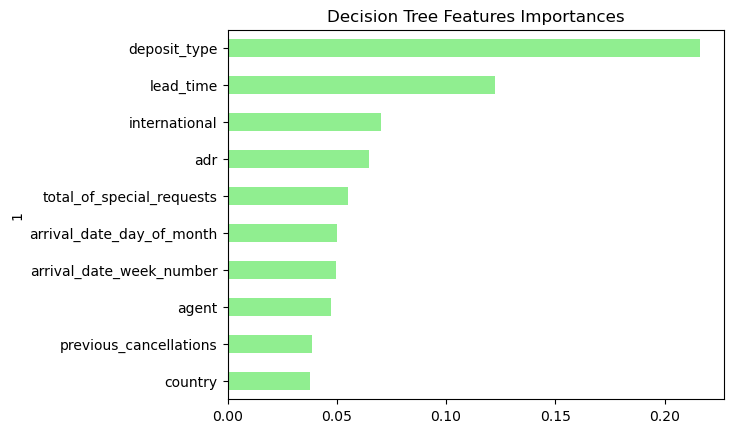

In [71]:
# Visualize the features by importance
dt_importances_df = pd.DataFrame(sorted(zip(model_dt.feature_importances_, X.columns), reverse=True))
dt_importances_df.set_index(dt_importances_df[1], inplace=True)
dt_importances_df.drop(columns=1, inplace=True)
dt_importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
dt_importances_sorted = dt_importances_df[:10].sort_values(by='Feature Importances')
dt_importances_sorted.plot(kind='barh', color='lightgreen', title= 'Decision Tree Features Importances', legend=False)

In [72]:
# Compare all results
results = pd.concat([lr_results, rf_results, dt_results])
results_sorted = results.sort_values(by='Accuracy Score', ascending=False).set_index('Model')
results_sorted

,Accuracy Score,F1 score,Precision,Recall
Model,,,,
Random Forest,0.890696,0.856458,0.877939,0.836004
Desicion Tree,0.852230,0.809679,0.813542,0.805851
Logistic regression,0.789310,0.697031,0.793695,0.621355
